Here we try and use VGG net since it has simpler architecture for small dataset which is perfect for our 50x50 pictures

We also try to run training of data augmentaion on separate data augmentation techniques

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import seaborn as sn

In [3]:
#Metode for å hente data frå mappe
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [4]:
#Hente data og sette til array
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [5]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [6]:
# Label array where BH is 0 and Sphalerons are 1
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [7]:
#Check if device is running on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [8]:
#Split data 75% into train and 25% into test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

Data augmentation process where we flip horizontally, and rotate images by 180 degrees randomly thus increasing training set.
As well as we siplace images top down on y axes

Commented out part where we crop images in width which can potentially increase models precision

In [9]:
def random_shift_y(img, roll_axis):
    shift = torch.randint(low=0, high=list(img.shape)[roll_axis], size=(1, 1)).item()
    img = torch.roll(img, shift, roll_axis)
    return img

def augment_images(images):
    images = np.moveaxis(images, -1, 1)
    augmented_images = []
    for img in images:
        img = torch.from_numpy(img)
        
        img_flipped_horizontal = torch.flip(img, dims=[2])
        img_flipped_vertical = random_shift_y(img, roll_axis=1)
        img_rotated_180 = torch.rot90(img, 2, dims=[1, 2])

        augmented_images.extend(
            [img, img_flipped_horizontal, img_flipped_vertical, img_rotated_180]
        )
    return torch.stack(augmented_images)  # Use torch.stack instead of np.array

# Apply data augmentation only on the training set
augmented_trainData = augment_images(trainData)

# Repeat the labels for the training set to match the augmented dataset
trainLabels_repeated = np.repeat(trainLabels, 4)

# Convert the augmented training data and repeated labels to PyTorch tensors
trainLabels_repeated = torch.from_numpy(trainLabels_repeated)

# Create a TensorDataset from the augmented training data and repeated labels
train_augmented = torch.utils.data.TensorDataset(augmented_trainData, trainLabels_repeated)

# Create a DataLoader for the augmented training dataset with shuffle enabled and batch size of 50
trainLoader_augmented = DataLoader(train_augmented, shuffle=True, batch_size=50)

# Apply the same preprocessing step to the test set as the training set
testData_processed = np.moveaxis(testData, -1, 1)

# Create a TensorDataset for the test data
test = torch.utils.data.TensorDataset(torch.from_numpy(testData_processed), torch.from_numpy(testLabels))

# Create a DataLoader for the test data with shuffle and batch size
testLoader = DataLoader(test, shuffle=True, batch_size=50)


This code allows us to look on orignial data image as well as its augmented forms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

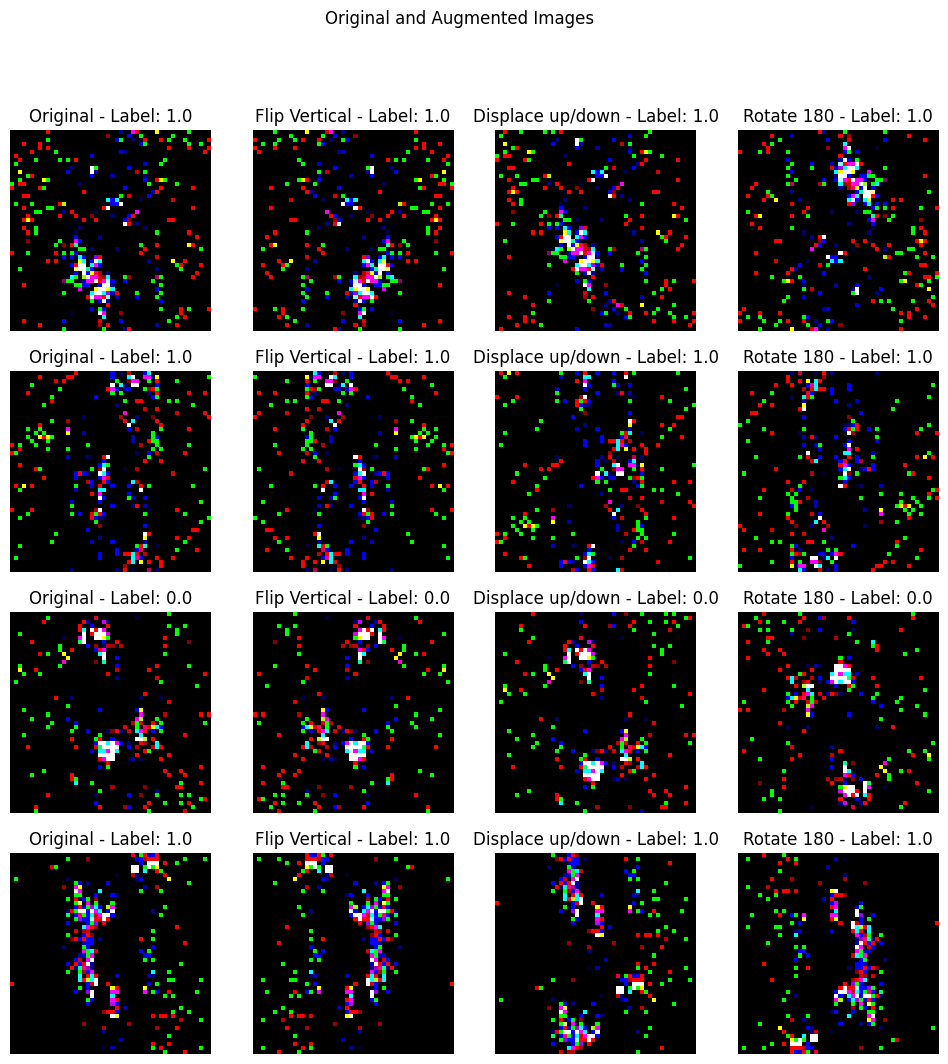

In [10]:
def visualize_comparison(original_images, augmented_images, labels, title, augmentation_info=None):
    n_images = len(original_images)
    n_columns = 4
    n_rows = n_images

    augmented_types = ['Original', 'Flip Vertical', 'Displace up/down', 'Rotate 180']

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(3 * n_columns, 3 * n_rows))
    fig.suptitle(title)

    for i in range(n_images):
        for j in range(n_columns):
            if j == 0:
                img = original_images[i]
            else:
                img = augmented_images[4 * i + j]

            if isinstance(img, np.ndarray):
                img_rgb = np.moveaxis(img, 0, -1) if img.shape[0] == 3 else img
            elif isinstance(img, torch.Tensor):
                img_rgb = np.moveaxis(img.numpy(), 0, -1)

            ax = axs[i, j]
            ax.imshow(img_rgb)
            ax.set_title(f"{augmented_types[j]} - Label: {'BH' if labels[i] == 1 else 'SPH'}") #Change labels such that if 1 Bh if 1 then Sph
            ax.axis('off')

    plt.show()

n_samples = 4
original_images = trainData[:n_samples]
original_labels = trainLabels[:n_samples]
augmented_images = augmented_trainData[:4 * n_samples]

visualize_comparison(original_images, augmented_images, original_labels, title="Original and Augmented Images")


Here we make a call on nnmodel.py in methods fodler where all our models resign

In [11]:
import nnmodel

model = nnmodel.ConvModel(0.5).to(device)  # Move the model to the appropriate device

# Print the model summary, make sure to provide appropriate input size (3, 50, 50) for the 3-channel 50x50 images
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
            Conv2d-2           [-1, 64, 22, 22]           9,280
            Conv2d-3            [-1, 256, 9, 9]         147,712
            Linear-4                  [-1, 128]         295,040
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
           Dropout-7                    [-1, 2]               0
Total params: 452,738
Trainable params: 452,738
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.68
Params size (MB): 1.73
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


This function allow us to plot all metrics

In [12]:
def plot_metrics(augmentation_types, all_metrics):
    num_types = len(augmentation_types)

    plt.figure(figsize=(20, 20))
    
    plot_index = 1
    for metric_name in all_metrics[0].keys():
        plt.subplot(4, 4, plot_index)
        for i, augment_type in enumerate(augmentation_types):
            plt.plot(all_metrics[i][metric_name], label=f'{augment_type} {metric_name}')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.title(f'{metric_name} with Different Augmentations')
        plot_index += 1

    plt.tight_layout()
    plt.show()

Here we make a call on train method from methods folder file trainers.py where all training and testing happends as well as plotting of accuracy, loss, precision, recall etc.

Few changes added scheduler and early stopping to prevent from overfitting with changing learning rate if test loss and accuracy doesnt improve. 

Here we train data and get plot of different augmentation techniques

Running on the GPU

Training with None augmentation
Epoch: 0/20
Train Loss: 0.7949, Train Accuracy: 63.82%
Test Loss: 0.4388, Test Accuracy: 82.00%
Epoch: 1/20
Train Loss: 0.4988, Train Accuracy: 73.46%
Test Loss: 0.3706, Test Accuracy: 83.77%
Epoch: 2/20
Train Loss: 0.4482, Train Accuracy: 76.83%
Test Loss: 0.3487, Test Accuracy: 85.93%
Epoch: 3/20
Train Loss: 0.4308, Train Accuracy: 77.22%
Test Loss: 0.3418, Test Accuracy: 86.75%
Epoch: 4/20
Train Loss: 0.4157, Train Accuracy: 77.81%
Test Loss: 0.3234, Test Accuracy: 86.32%
Epoch: 5/20
Train Loss: 0.4105, Train Accuracy: 77.90%
Test Loss: 0.3002, Test Accuracy: 88.27%
Epoch: 6/20
Train Loss: 0.3898, Train Accuracy: 78.97%
Test Loss: 0.3418, Test Accuracy: 84.63%
Epoch: 7/20
Train Loss: 0.3922, Train Accuracy: 79.01%
Test Loss: 0.3091, Test Accuracy: 87.80%
Epoch: 8/20
Train Loss: 0.3878, Train Accuracy: 78.88%
Test Loss: 0.2863, Test Accuracy: 87.97%
Epoch: 9/20
Train Loss: 0.3745, Train Accuracy: 79.50%
Test Loss: 0.2941, Test Accur

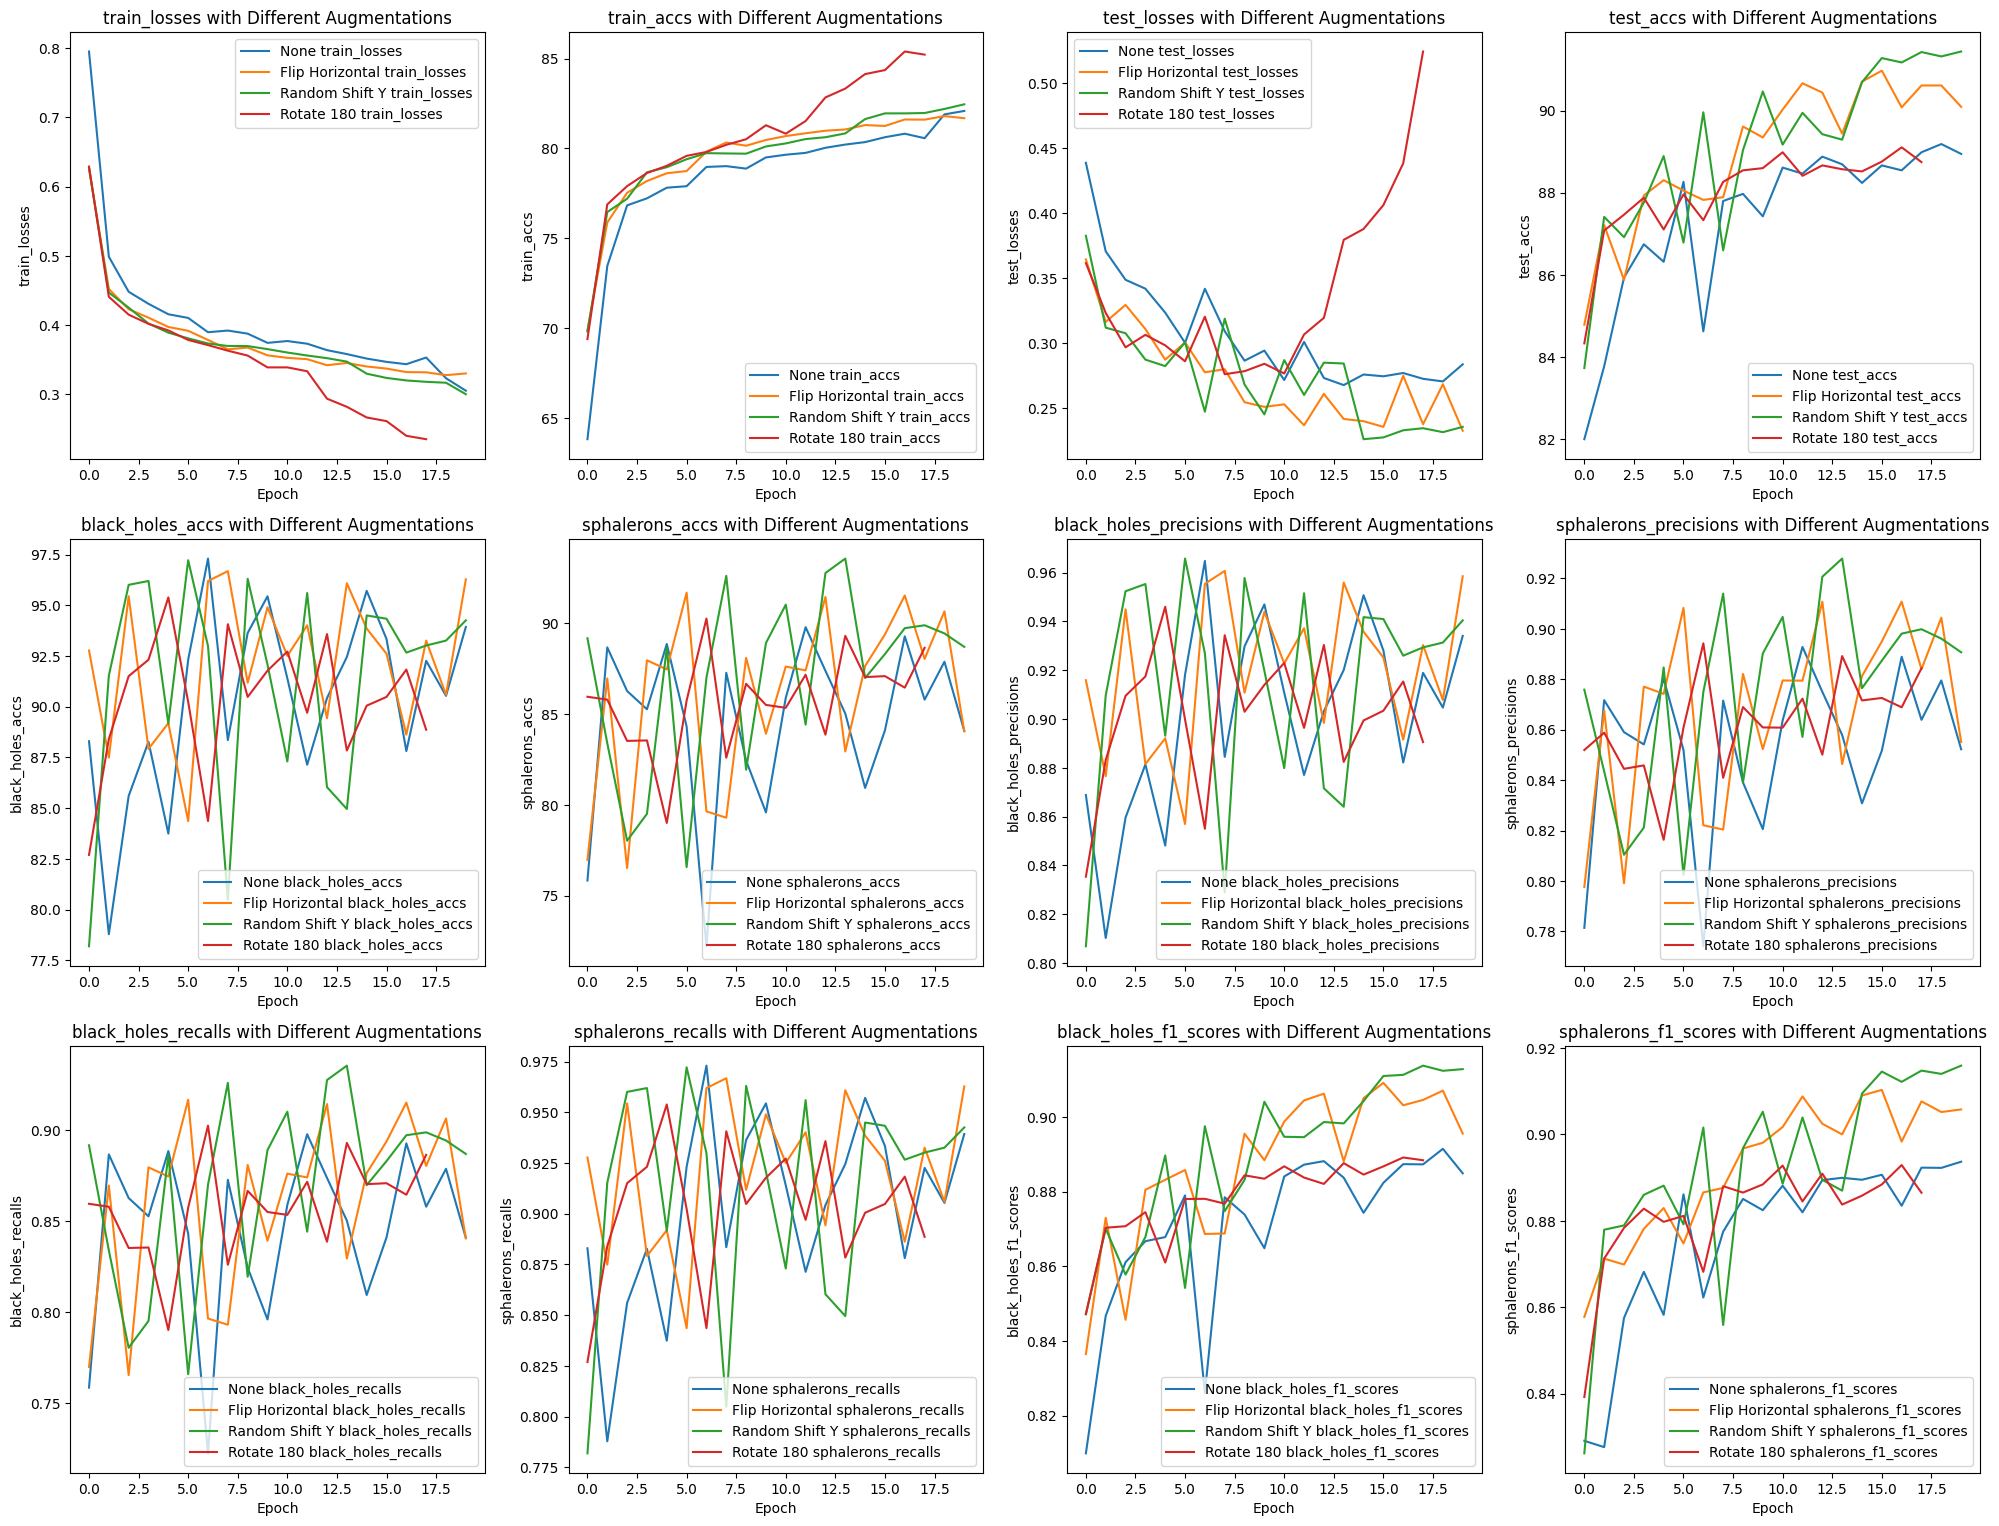

In [13]:
import trainerDataAug

def train_with_augmentations(augmentation_types):
    all_metrics = []
    for augment_type in augmentation_types:
        print(f"\nTraining with {augment_type} augmentation")

        # Filter the augmented training data based on the augmentation type
        filter_indices = list(range(0, len(augmented_trainData), 4))  # Original images are always included
        if augment_type != "None":
            aug_type_index = augmentation_types.index(augment_type)
            filter_indices += list(range(aug_type_index + 1, len(augmented_trainData), 4))
        filtered_trainData = augmented_trainData[filter_indices]
        filtered_trainLabels = trainLabels_repeated[filter_indices]

        # Create a TensorDataset and DataLoader for the filtered training data
        train_filtered = torch.utils.data.TensorDataset(filtered_trainData, filtered_trainLabels)
        trainLoader_filtered = DataLoader(train_filtered, shuffle=True, batch_size=50)

        # Train the model with the filtered training data
        model = nnmodel.ConvModel(0.5).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss().to(device)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)
        metrics = trainerDataAug.train(model, trainLoader_filtered, testLoader, optimizer, criterion, n_epochs=20, scheduler = scheduler, early_stopping_patience=10)

        all_metrics.append(metrics)
    
    plot_metrics(augmentation_types, all_metrics)
# Train and compare the model with different data augmentations
augmentation_types = ["None", "Flip Horizontal", "Random Shift Y", "Rotate 180"]
train_with_augmentations(augmentation_types)

Code below makes it possible to save model

In [14]:
# #save model
# torch.save(model.state_dict(), model_save_path)

# # Load the saved model
# model.load_state_dict(torch.load(model_save_path))

# # Set the model to evaluation mode
# model.eval()

# # Function to test the model
# def test_model(model, test_loader, device):
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             _, predicted = torch.max(output.data, 1)
#             total += target.size(0)
#             correct += (predicted == target).sum().item()

#     accuracy = 100 * correct / total
#     print(f"Accuracy of the model on test data: {accuracy}%")

# # Test the model
# test_model(model, testLoader, device)